# Tweet Analysis

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sqlite3
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
stop_words = stopwords.words('english')
%matplotlib inline

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [3]:
# conn = sqlite3.connect("en_lupus.sqlite") # open the SQLite connection 
# tweets = pd.read_sql_query("SELECT * FROM hashtags;", conn) # get all the tweets
# tweets['created_at'] = pd.to_datetime(tweets['created_at']) # convert strings to timestamps  
# orig_tweets = tweets[tweets['retweeted_status'] == 0] # only original tweets, i.e. no retweets
# conn.close() # close the SQLite connection

### Get the CSV

In [4]:
df = pd.read_csv('./train/lupus_classification.csv')
df.columns = ['username', 'time', 'content', 'NA', 'P', 'F', 'M', 'A', 'U']
df['index'] = range(1, len(df) + 1)
# df = df.set_index('index')
df.head()

,username,time,content,NA,P,F,M,A,U,index
0,taeiae,00:56.0,i finished the first lupus tales fic and now i...,NaN,NaN,NaN,NaN,NaN,NaN,1
1,mistykj05,59:36.0,Co-ed floor same as my son. I didn't get to dr...,NaN,x,NaN,NaN,NaN,NaN,2
2,@DamonkWayans @keeshash,arp @dantebro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,linmp1031,56:58.0,@ajstarr10 @therealzanetta Who makes a pkgd sa...,NaN,x,x,NaN,NaN,NaN,4
4,_CrazyWonderful,55:04.0,I‚Äôm determined to connect with other #lupusw...,NaN,x,NaN,NaN,NaN,NaN,5


In [5]:
df2 = pd.read_csv('./train/november400.csv')
df2.columns = ['tweet_id', 'username', 'time', 'content', 'NA', 'P', 'F', 'M', 'A']
df2.head()

,tweet_id,username,time,content,NA,P,F,M,A
0,9.260000e+17,biotweeps,53:28.0,Atlantic Wolffish (Anarhichas lupus) is also s...,x,NaN,NaN,NaN,NaN
1,9.260000e+17,ohellvis,52:12.0,"@JOHN__JUAN @RapUp bitch, no one! but I think ...",NaN,x,NaN,NaN,NaN
2,9.260000e+17,LupusCorner,52:08.0,2 goals of topical treatments for cutaneous &a...,NaN,NaN,NaN,x,NaN
3,9.260000e+17,DaIaiGoat,51:23.0,@JaguarPaw90 @tellmecarey It's not heartless. ...,NaN,x,NaN,NaN,NaN
4,9.260000e+17,JaguarPaw90,48:54.0,@tellmecarey @DaIaiGoat She almost died from l...,NaN,x,NaN,NaN,NaN


### Clean the data 

In [6]:
df = df.dropna(subset=['content'])
df = df.dropna(subset=['NA', 'P', 'F', 'M', 'A'], how='all') 
print("Tweet count:", len(df))

Tweet count: 262


In [7]:
def get_category_number(row): 
    if not pd.isnull(row['NA']): 
        return 0
    if not pd.isnull(row['P']): 
        return 1
    if not pd.isnull(row['F']): 
        return 2
    if not pd.isnull(row['M']): 
        return 3
    if not pd.isnull(row['A']): 
        return 4
    return 0

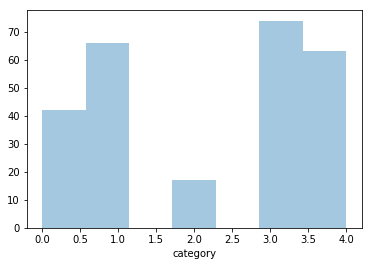

In [8]:
df['category'] = df.apply(lambda r: get_category_number(r), axis = 1)
df = df[df['category'] >= 0]
sns.distplot(df['category'], kde=False)

In [9]:
df = df[['index', 'content', 'category']]

In [10]:
df.head()

,index,content,category
1,2,Co-ed floor same as my son. I didn't get to dr...,1
3,4,@ajstarr10 @therealzanetta Who makes a pkgd sa...,1
4,5,I‚Äôm determined to connect with other #lupusw...,1
5,6,New Blog: My open letter to @selenagomez about...,1
7,8,@LADAOrg so happy I found this page!! #iamnot...,1


In [11]:
y = df['category'].values
xtrain, xvalid, ytrain, yvalid = train_test_split(df['content'].values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

# GloVe

In [12]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

embeddings_index = {}
f = open('../../glove/glove.840B.300d.txt')
count = 0

# 2 196 017

for line in f:
    count = count + 1
    if (count % 100000 == 0): 
        print(count)
    values = line.split()
    word = values[0]
    i = 1
    while not isfloat(values[i]):
        word = word + ' ' + values[i]
        i = i + 1
    if i > 1:
        print('Exceptional case: {0}'.format(word))
    coefs = np.asarray(values[i:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Exceptional case: . . .
100000
Exceptional case: at name@domain.com
Exceptional case: . . . . .
200000
Exceptional case: to name@domain.com
Exceptional case: . .
Exceptional case: . . . .
Exceptional case: email name@domain.com
300000
Exceptional case: or name@domain.com
400000
500000
Exceptional case: contact name@domain.com
600000
700000
Exceptional case: Email name@domain.com
800000
900000
Exceptional case: on name@domain.com
1000000
1100000
Exceptional case: At Killerseats.com
Exceptional case: by name@domain.com
1200000
1300000
Exceptional case: in mylot.com
1400000
Exceptional case: emailing name@domain.com
1500000
Exceptional case: Contact name@domain.com
1600000
1700000
1800000
Exceptional case: at name@domain.com
1900000
Exceptional case: • name@domain.com
2000000
Exceptional case: at Amazon.com
2100000
Exceptional case: is name@domain.com


In [13]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower() ## .decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [14]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in xtrain]
xvalid_glove = [sent2vec(x) for x in xvalid]

In [15]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [16]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

In [17]:
print ("xgb logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

xgb logloss: 1.195 


## Deep Learning

In [18]:
scl = StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [19]:
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [20]:
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(5))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [21]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Train on 235 samples, validate on 27 samples
Epoch 1/5
235/235 [==============================] - 1s 5ms/step - loss: 1.7522 - val_loss: 0.9018
Epoch 2/5
235/235 [==============================] - 0s 153us/step - loss: 0.9787 - val_loss: 0.7199
Epoch 3/5
235/235 [==============================] - 0s 147us/step - loss: 0.6379 - val_loss: 0.6833
Epoch 4/5
235/235 [==============================] - 0s 155us/step - loss: 0.4176 - val_loss: 0.6902
Epoch 5/5
235/235 [==============================] - 0s 179us/step - loss: 0.3474 - val_loss: 0.6988


In [22]:
predictions = model.predict(x=xvalid_glove_scl)

In [23]:
print ("ANN logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

ANN logloss: 0.699 
